<a href="https://colab.research.google.com/github/NeuroLife77/BIOL309_final_project/blob/main/biol309_final_project_1d_bifurcations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This cell is the "setup" so run it but don't worry about what's inside
To run a cell you can click on the play button at the top left of the cell (or click anywhere inside the cell and use the shortcut ctrl+enter)

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from scipy.signal import periodogram

# Heun integration scheme accelerated by numba
@numba.njit
def simulate_heun(fn, x0, parameters, dt = 0.1, length = 5.0, transient_removed = 4.0):
  # Default is 5sec simulation at 0.1ms step size, removing the first 4 sec
  num_steps = int(length*1000/dt)
  num_transient = int(transient_removed*1000/dt)
  # Setting up the array to collect the time points
  time_series = np.zeros((num_steps+1,3))
  # Set up initial conditions
  time_series[0] = x0
  # Forward steps
  for i in range(num_steps):
    time_series[i+1] = fn(time_series[i],parameters)*dt
    time_series_temp = time_series[i]+time_series[i+1]
    time_series_corr = fn(time_series_temp,parameters)*dt
    time_series[i+1] = time_series[i] + (time_series[i+1]+time_series_corr)/2 
  # Return the time series (minus transients)
  return time_series[num_transient:,:]

# Model equations
@numba.njit
def sigI(z):
  return 1/(1+np.exp(-2*(z-3.7)))
@numba.njit
def sigE(z,M,cm):
  return 1/(1+np.exp(-1.3*(z-4*(1-cm*M))))
@numba.njit
def Edot(E, I, M, cee,cie,taue,cm):
  return 1/taue * (-E+(1-E)*(sigE(cee*E-cie*I+1.25,M,cm)))
@numba.njit
def Mdot(E,M, taum,E_max):
  return (-M + (1-M)*(E_max-E))/taum 
@numba.njit
def Idot(E,I,cei,cii,taui):
  return 1/taui * (-I+(1-I)*(sigI(cei*E-cii*I)))

# Wrapper for integration function call
@numba.njit
def fn(state_var,parameters):
  E, I, M = state_var[0],state_var[1], state_var[2]
  cee, cie, cei, cii = parameters[0], parameters[1], parameters[2], parameters[3]
  taue, taui = parameters[4], parameters[5]
  cm, taum, E_max = parameters[6], parameters[7], parameters[8]
  output = np.array([Edot(E, I, M, cee, cie, taue, cm), Idot(E, I, cei, cii, taui), Mdot(E, M, taum, E_max)])
  return output

# Global variables to keep track of things 
# Also allows easy interface and automated adaptive plots for non-coders in the group
parameter_indices = { "cee":0,"cei":1,"cie":2,"cii":3,"taue":4,"taui":5,"cm":6,"taum":7,"E_max":8}
latex = {"cee":"$c_{ee}$", "cei":"$c_{ei}$", "cie":"$c_{ie}$","cii":"$c_{ii}$","taue":"$\\tau_{e}$", "taui":"$\\tau_{i}$","cm":"$c_{m}$","taum":"$\\tau_{m}$", "E_max":"$E_{max}$",}
initial_cond_list = []
for i in range(5):
  for j in range(5):
    initial_conditions_index = i+5*j
    initial_cond_list.append([f"$E_0={round(0.2*i,1)}$",f"$I_0={round(0.2*j,1)}$"])

# Interface to obtain the time series from the dictionary of parameter values
def get_simulation(parameter_dict, initial_cond = [0.5,0.5]):
  M_parameters = np.array([
    parameter_dict[item] for item in parameter_dict
  ])
  ts = simulate_heun(fn,np.array([initial_cond[0],initial_cond[0],0]),M_parameters)
  return ts

# Function to produce the data for bifurcation plots from the dictionary interface
def get_bifurcation(parameter_dict,bifurcation_settings):
  # Set up the simulation parameters using the dictionaries
  M_parameters = np.array([
      parameter_dict[item] for item in parameter_dict
  ])
  bif_par = parameter_indices[bifurcation_settings["bifurcation_parameter"]]
  bifurcation_par_range = np.linspace(*bifurcation_settings["bifurcation_range"],bifurcation_settings["bifurcation_resolution"])
  # Variable to collect the data
  bifurcation = np.zeros((bifurcation_par_range.shape[0],25,2,3))
  frequency = np.zeros((bifurcation_par_range.shape[0],25,2))
  # Iterate over all parameter values for the bifurcation
  for par_index, par_val in enumerate(bifurcation_par_range):
    # Set parameter value
    M_parameters[bif_par]=par_val
    # Run 25 initial conditions for E & I as a 5x5 grid
    for i in range(5):
      for j in range(5):
        # Flattened index of the initial condition
        initial_conditions_index = i+5*j
        # Simulate
        ts = simulate_heun(fn, np.array([0.2*i,0.2*j,0]), M_parameters)
        # Keep the min and max of the time series
        bifurcation[par_index, initial_conditions_index,0,:] = ts.min(0)
        bifurcation[par_index, initial_conditions_index,1,:] = ts.max(0)
        # Compute the peak frequency of the time series
        freq, power = periodogram(ts,fs = 10000,axis=0)
        frequency[par_index, initial_conditions_index, 0] = freq[power[:,0].argmax()]
        frequency[par_index, initial_conditions_index, 1] = freq[power[:,1].argmax()]
        

  # Collapse the 25 initial conditions with the min-max axis for easy plotting      
  bifurcation_E = bifurcation[:,:,:,0].reshape((bifurcation_par_range.shape[0],50))
  bifurcation_I = bifurcation[:,:,:,1].reshape((bifurcation_par_range.shape[0],50))
  # Return all necessary values
  return bifurcation_E, bifurcation_I, bifurcation_par_range, frequency

## This is where you start using things

The "parameter_dict" variable contains the values of the parameters for the model that are fixed. Change them to specify the model's "fixed" parameters if necessary.

The "bifurcation_settings" variable contains the information to make the bifurcation plots:
- "bifurcation_parameter" is the name of the parameter you want to use for the bifurcation, it should be exactly the same as in "parameter_dict", so just copy/paste the name from it.
- "bifurcation_range" is a list of [min, max] values for the bifurcation parameter.
- "bifurcation_resolution" is how many points are used to draw the bifurcation diagram.

In [88]:
# Run the cell to get the data for the bifurcation plot

# Change the the parameter_dict to fix parameter values
parameter_dict = {
    "cee":16,    # [10, 16]
    "cei":15,    # [2, 15]
    "cie":12,    # [2, 15]
    "cii":3,     # [2, 15]
    "taue":8,    # [1, 50]
    "taui":30,   # [1, 50]
    "cm":0.0,    # [0, 1] fixed don't change (will be automatically changed)
    "taum":100,  # fixed don't change
    "E_max":0.5  # [0, 1] fixed don't change (not used in the tests here)
}
# Chose the parameter that you want to vary, and define the range & resolution of the bifurcation diagram 
bifurcation_settings = {
    "bifurcation_parameter":"cii",
    "bifurcation_range":[2, 15.0],  # [min_val, max_val]
    "bifurcation_resolution":50     # Note: A resolution of 50 takes ~50sec to run
}

# This runs the test with the original model (with modulatory input OFF)
bifurcation_E, bifurcation_I, parameter_range, frequency = get_bifurcation(parameter_dict,bifurcation_settings)
# This runs the test with the new model (with modulatory input ON)
parameter_dict["cm"] = 1.0
bifurcation_E_cm, bifurcation_I_cm, _, frequency_cm = get_bifurcation(parameter_dict,bifurcation_settings)

## This is to plot the bifurcation that you produced in the cell above

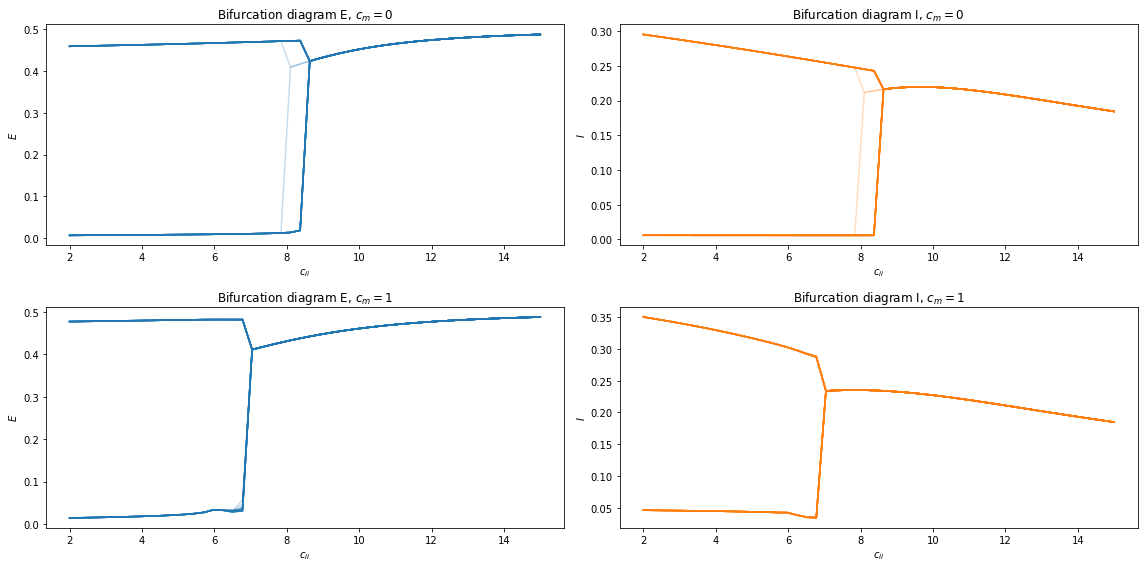

In [90]:
# Run this cell after the one above to plot the bifurcations

par_latex = latex[bifurcation_settings["bifurcation_parameter"]]
par_range = parameter_range.reshape((-1,1))

fig = plt.figure(figsize=(16,8))

# Make the plots for original model bifurcations
ax = plt.subplot(2,2,1)
ax.plot(par_range, bifurcation_E, 'C0', alpha=.25)
plt.title("Bifurcation diagram E, $c_m = 0$")
plt.xlabel(f"{par_latex}")
plt.ylabel("$E$")
ax = plt.subplot(2,2,2)
ax.plot(par_range, bifurcation_I, 'C1', alpha=.25)
plt.title("Bifurcation diagram I, $c_m = 0$")
plt.xlabel(f"{par_latex}")
plt.ylabel("$I$")

# Make the plots for new model bifurcations
ax = plt.subplot(2,2,3)
ax.plot(par_range, bifurcation_E_cm, 'C0', alpha=.25)
plt.title("Bifurcation diagram E, $c_m = 1$")
plt.xlabel(f"{par_latex}")
plt.ylabel("$E$")
ax = plt.subplot(2,2,4)
ax.plot(par_range, bifurcation_I_cm, 'C1', alpha=.25)
plt.title("Bifurcation diagram I, $c_m = 1$")
plt.xlabel(f"{par_latex}")
plt.ylabel("$I$")

plt.tight_layout()
plt.show()

## This is to investigate the frequency of the time series
The cell above will tell you if there is a fixed point or a cycle, but it won't tell you what the cycle looks like. The cell below will plot the frequency of the cycle if there is one. A fixed point should have a frequency of 0.

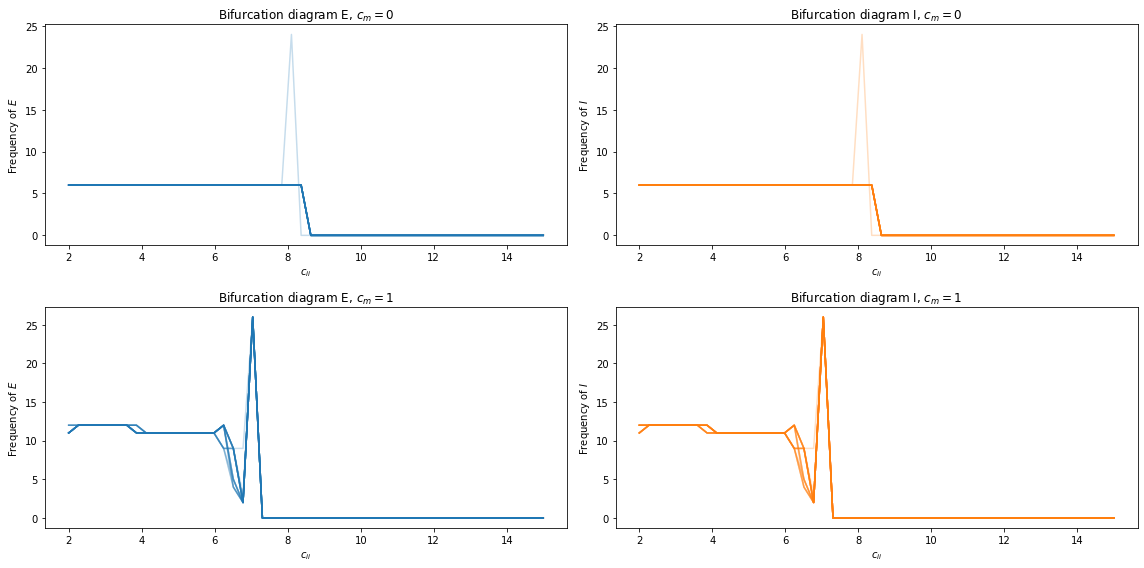

In [91]:
fig = plt.figure(figsize=(16,8))

# Make the plots for original model bifurcations
ax = plt.subplot(2,2,1)
ax.plot(par_range, frequency[:,:,0], 'C0', alpha=.25)
plt.title("Bifurcation diagram E, $c_m = 0$")
plt.xlabel(f"{par_latex}")
plt.ylabel("Frequency of $E$")
ax = plt.subplot(2,2,2)
ax.plot(par_range, frequency[:,:,1], 'C1', alpha=.25)
plt.title("Bifurcation diagram I, $c_m = 0$")
plt.xlabel(f"{par_latex}")
plt.ylabel("Frequency of $I$")

# Make the plots for new model bifurcations
ax = plt.subplot(2,2,3)
ax.plot(par_range, frequency_cm[:,:,0], 'C0', alpha=.25)
plt.title("Bifurcation diagram E, $c_m = 1$")
plt.xlabel(f"{par_latex}")
plt.ylabel("Frequency of $E$")
ax = plt.subplot(2,2,4)
ax.plot(par_range, frequency_cm[:,:,1], 'C1', alpha=.25)
plt.title("Bifurcation diagram I, $c_m = 1$")
plt.xlabel(f"{par_latex}")
plt.ylabel("Frequency of $I$")

plt.tight_layout()
plt.show()

## If you want to see what happens at certain points of the bifurcation
Change the value of "parameter_value" below to the value of interest and run the cell. It will produce a time series that you will be able to plot in the later cell.

In [93]:
# Write the value of interest here:
parameter_value = 8.5

# If you find that some bifurcation is different at specific initial conditions you can specify them here to see what happens
# For example, here it appears that initial conditions closer to the bifurcation state values make it happen at lower values of cii
initial_cond = [0.25, 0.45]

# This simulates with that specific value and returns the time series to plot in the cell below
parameter_dict[bifurcation_settings["bifurcation_parameter"]] = par_interest = parameter_value
parameter_dict["cm"] = 0.0
ts0 = get_simulation(parameter_dict, initial_cond = initial_cond)
parameter_dict["cm"] = 1.0
ts1 = get_simulation(parameter_dict, initial_cond = initial_cond)

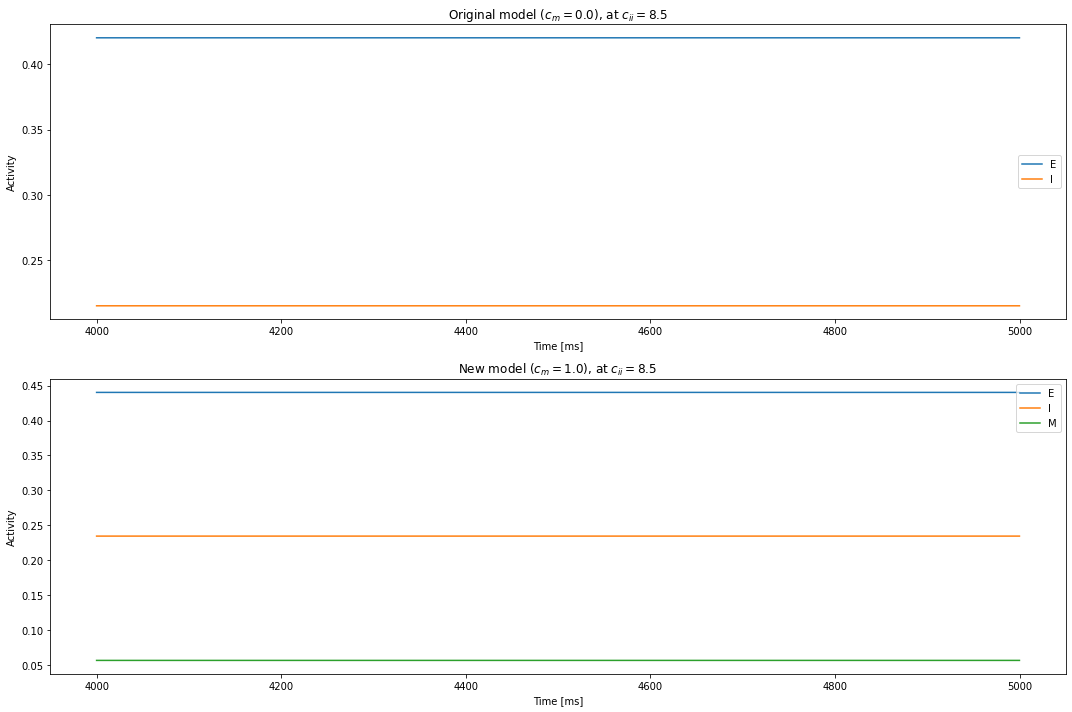

In [94]:
# Run this cell to plot the time series of the state variables for the parameter value of interest

t = np.arange(int(1000/0.1))*0.1 + 4000

f = plt.figure(figsize=(15,10))

# Plot time series for the original model
ax = plt.subplot(2,1,1)
ax.plot(t,ts0[1:,0], label = "E")
ax.plot(t,ts0[1:,1], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.legend()
plt.title(f'Original model ($c_m = 0.0$), at {par_latex}$={par_interest}$')

# Plot time series for the new model
ax = plt.subplot(2,1,2)
ax.plot(t,ts1[1:,0], label = "E")
ax.plot(t,ts1[1:,1], label = "I")
ax.plot(t,ts1[1:,2], label = "M")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.legend()
plt.title(f'New model ($c_m = 1.0$), at {par_latex}$={par_interest}$')

plt.tight_layout()
plt.show()

## Investigating sensitivity to initial conditions
If you find that you have multiple non-overlapping bifurcations then run this cell, it will plot the bifurcation diagram separately for all initial conditions.

This cell will show the results for the original model, and the one below will show the results for the new model (with $c_m = 1.0$) 

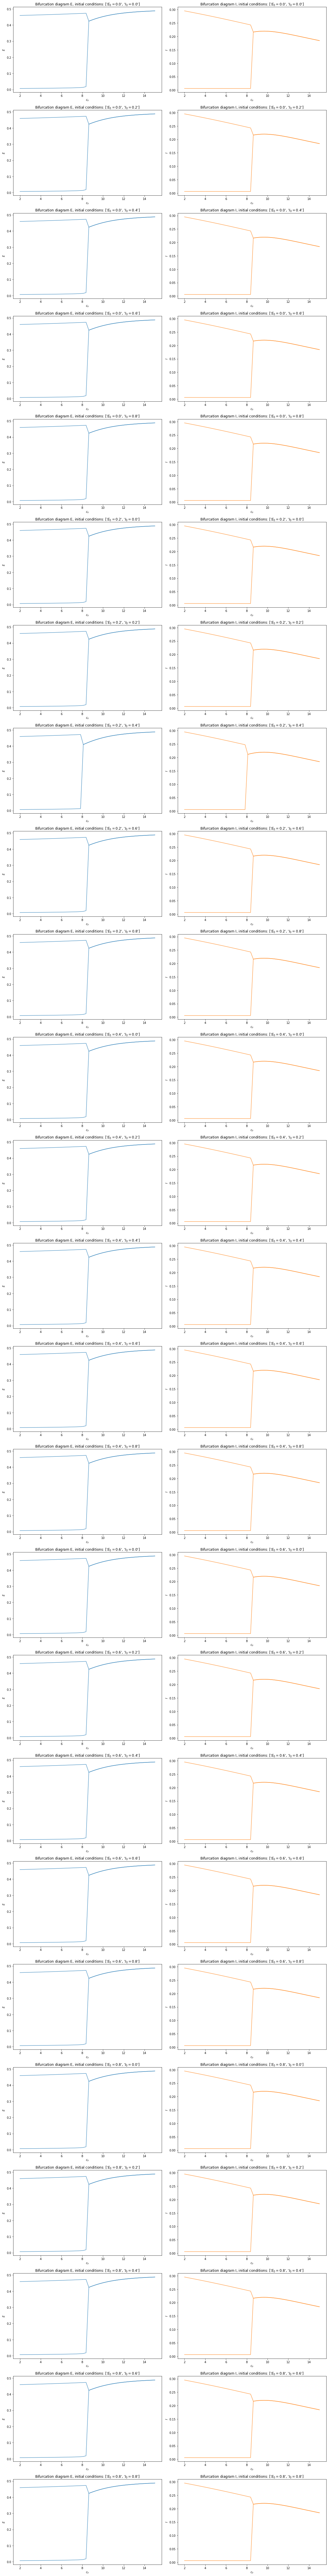

In [95]:
# Run this cell to plot the 50 bifurcation diagrams (25 initial conditions as rows and 2 state variabes as columns)

# Separate the different initial conditions
bifurcation_E_separate_initial_conditions = bifurcation_E.reshape((parameter_range.shape[0],25,2))
bifurcation_I_separate_initial_conditions = bifurcation_I.reshape((parameter_range.shape[0],25,2))

fig = plt.figure(figsize=(16,5*25))
# Plot the bifurcation for each initial condition separately (each row is a different initial condition)
for i in range(25):
  ax = plt.subplot(25,2,1+2*i)
  ax.plot(par_range, bifurcation_E_separate_initial_conditions[:,i,:], 'C0', alpha=.75)
  plt.title(f"Bifurcation diagram E, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("$E$")
  ax = plt.subplot(25,2,2+2*i)
  ax.plot(par_range, bifurcation_I_separate_initial_conditions[:,i,:], 'C1', alpha=.75)
  plt.title(f"Bifurcation diagram I, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("$I$")
plt.tight_layout()
plt.show()

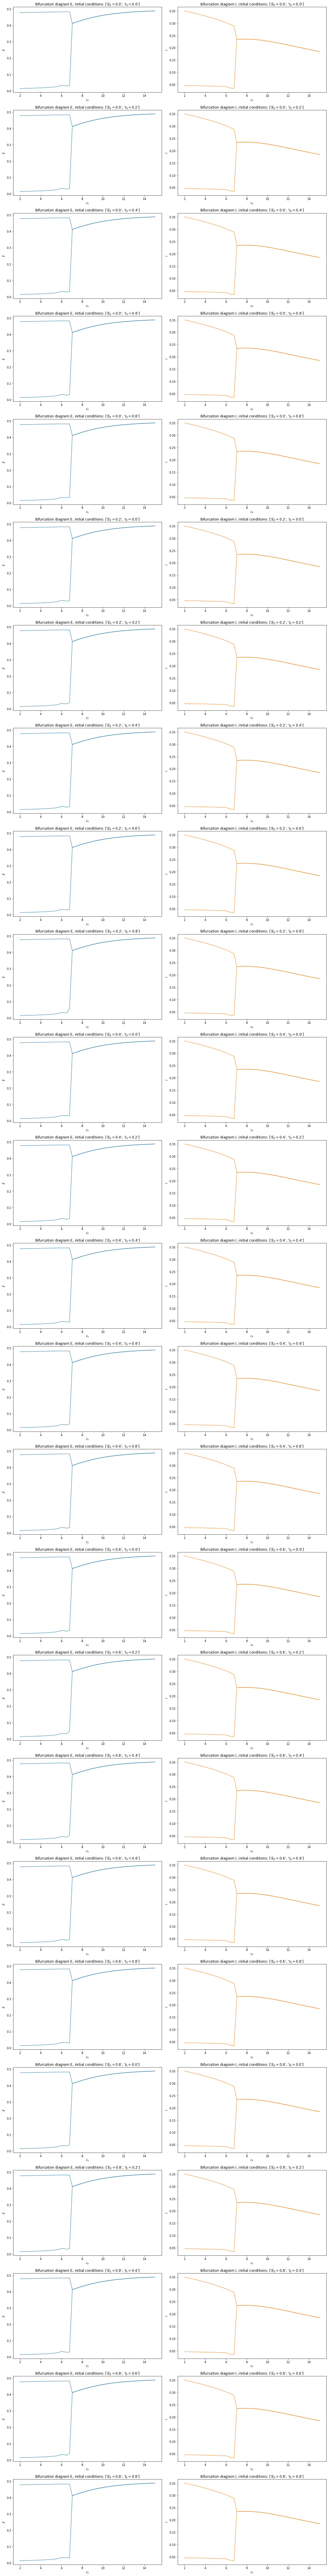

In [96]:
# Run this cell to plot the 50 bifurcation diagrams (25 initial conditions as rows and 2 state variabes as columns)

# Separate the different initial conditions
bifurcation_E_cm_separate_initial_conditions = bifurcation_E_cm.reshape((parameter_range.shape[0],25,2))
bifurcation_I_cm_separate_initial_conditions = bifurcation_I_cm.reshape((parameter_range.shape[0],25,2))

fig = plt.figure(figsize=(16,5*25))
# Plot the bifurcation for each initial condition separately (each row is a different initial condition)
for i in range(25):
  ax = plt.subplot(25,2,1+2*i)
  ax.plot(par_range, bifurcation_E_cm_separate_initial_conditions[:,i,:], 'C0', alpha=.75)
  plt.title(f"Bifurcation diagram E, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("$E$")
  ax = plt.subplot(25,2,2+2*i)
  ax.plot(par_range, bifurcation_I_cm_separate_initial_conditions[:,i,:], 'C1', alpha=.75)
  plt.title(f"Bifurcation diagram I, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("$I$")
plt.tight_layout()
plt.show()

## This is to investigate the frequency of the bifurcations
The same process as the 2 cells above, but showing the frequency instead of the min-max values.

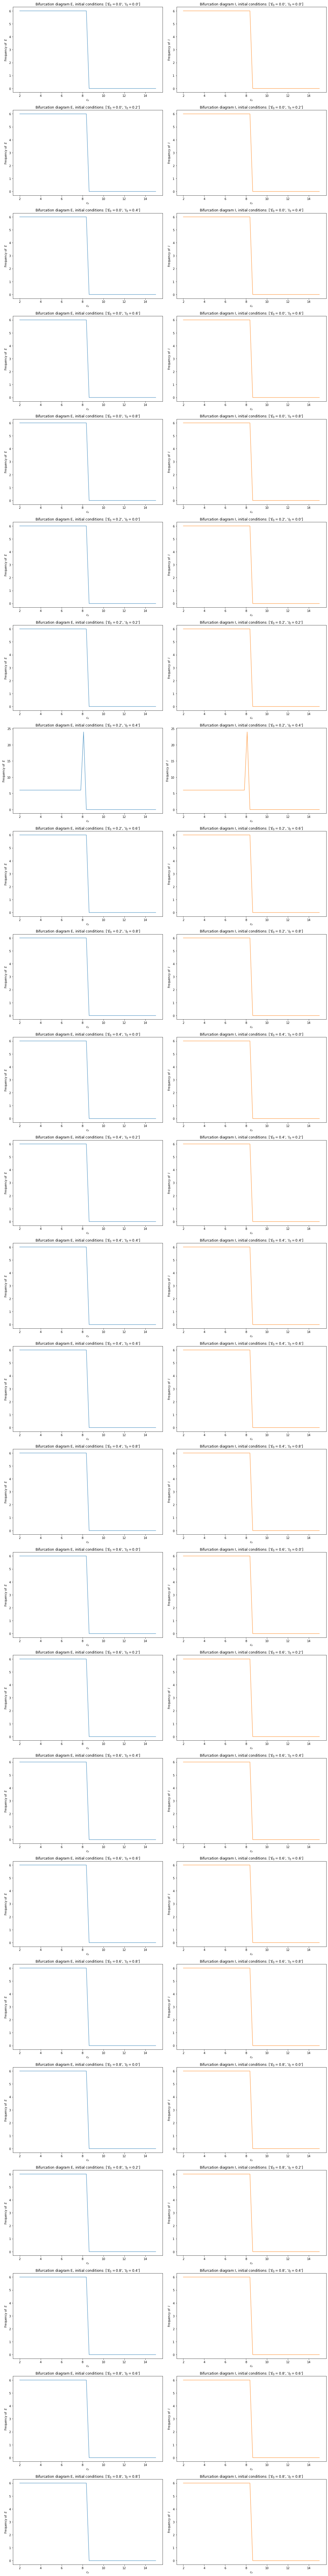

In [97]:
# Run this cell to plot the 50 bifurcation diagrams (25 initial conditions as rows and 2 state variabes as columns)

# Separate the different initial conditions
freq_bifurcation_E_separate_initial_conditions = frequency[:,:,0].reshape((parameter_range.shape[0],25))
freq_bifurcation_I_separate_initial_conditions = frequency[:,:,1].reshape((parameter_range.shape[0],25))

fig = plt.figure(figsize=(16,5*25))
# Plot the bifurcation for each initial condition separately (each row is a different initial condition)
for i in range(25):
  ax = plt.subplot(25,2,1+2*i)
  ax.plot(par_range, freq_bifurcation_E_separate_initial_conditions[:,i], 'C0', alpha=.75)
  plt.title(f"Bifurcation diagram E, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("Frequency of  $E$")
  ax = plt.subplot(25,2,2+2*i)
  ax.plot(par_range, freq_bifurcation_I_separate_initial_conditions[:,i], 'C1', alpha=.75)
  plt.title(f"Bifurcation diagram I, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("Frequency of  $I$")
plt.tight_layout()
plt.show()

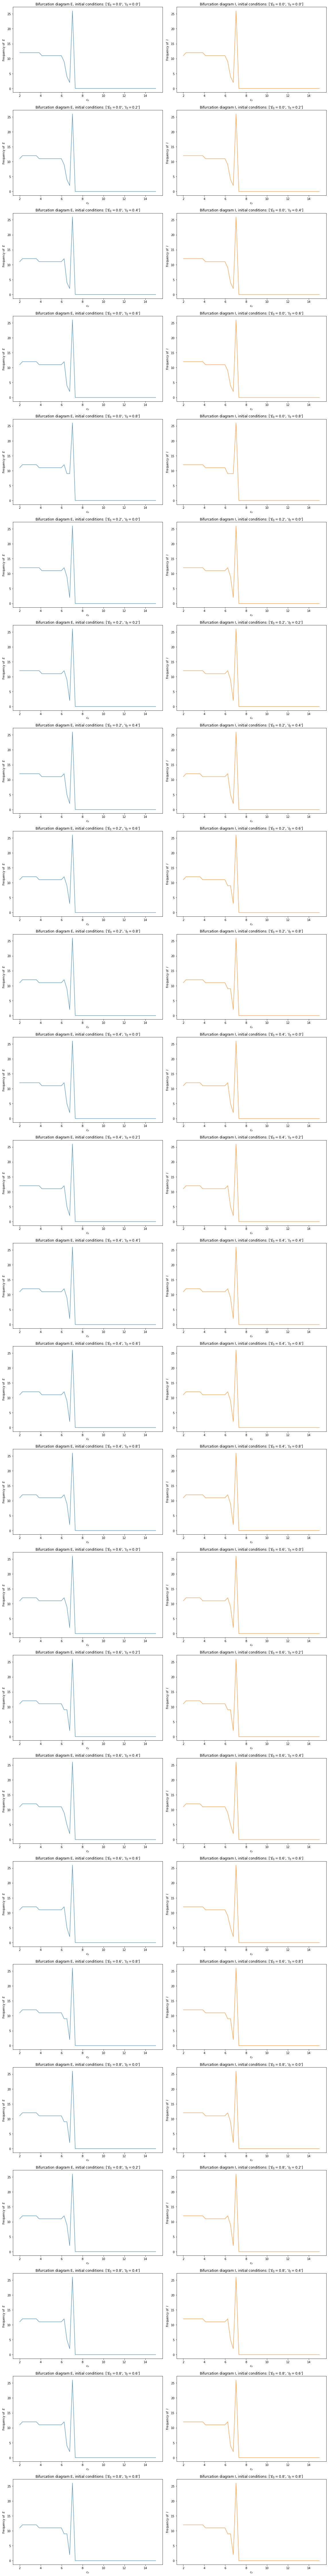

In [98]:
# Run this cell to plot the 50 bifurcation diagrams (25 initial conditions as rows and 2 state variabes as columns)

# Separate the different initial conditions
freq_bifurcation_E_cm_separate_initial_conditions = frequency_cm[:,:,0].reshape((parameter_range.shape[0],25))
freq_bifurcation_I_cm_separate_initial_conditions = frequency_cm[:,:,1].reshape((parameter_range.shape[0],25))

fig = plt.figure(figsize=(16,5*25))
# Plot the bifurcation for each initial condition separately (each row is a different initial condition)
for i in range(25):
  ax = plt.subplot(25,2,1+2*i)
  ax.plot(par_range, freq_bifurcation_E_cm_separate_initial_conditions[:,i], 'C0', alpha=.75)
  plt.title(f"Bifurcation diagram E, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("Frequency of  $E$")
  ax = plt.subplot(25,2,2+2*i)
  ax.plot(par_range, freq_bifurcation_I_cm_separate_initial_conditions[:,i], 'C1', alpha=.75)
  plt.title(f"Bifurcation diagram I, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("Frequency of  $I$")
plt.tight_layout()
plt.show()